In [1]:
!pip install einops
from einops import rearrange

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!gdown https://drive.google.com/uc?id=1lWTIkjK53YfXHy8HoOH4spNyvAEiDxI2
!mv Dataset_Student_annot_copy.zip Dataset_Student_annot.zip
#https://drive.google.com/file/d/1lWTIkjK53YfXHy8HoOH4spNyvAEiDxI2/view?usp=share_link
!unzip Dataset_Student_annot.zip

Downloading...
From: https://drive.google.com/uc?id=1lWTIkjK53YfXHy8HoOH4spNyvAEiDxI2
To: /content/Dataset_Student_annot_copy.zip
  7% 660M/10.1G [00:02<00:35, 266MB/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/response.py", line 444, in _error_catcher
    yield
  File "/usr/local/lib/python3.10/dist-packages/urllib3/response.py", line 567, in read
    data = self._fp_read(amt) if not fp_closed else b""
  File "/usr/local/lib/python3.10/dist-packages/urllib3/response.py", line 533, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
  File "/usr/lib/python3.10/http/client.py", line 466, in read
    s = self.fp.read(amt)
  File "/usr/lib/python3.10/socket.py", line 699, in readinto
    self._checkClosed()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 8, in <module>
    sys.exit(main())
  File "/usr/

In [16]:
!gdown https://drive.google.com/uc?id=1hw08A39sJY_qoTpTGGLL6yDV-4o9cWMY
#https://drive.google.com/file/d/1hw08A39sJY_qoTpTGGLL6yDV-4o9cWMY


Downloading...
From: https://drive.google.com/uc?id=1hw08A39sJY_qoTpTGGLL6yDV-4o9cWMY
To: /content/unlabeled_set_masks.zip
100% 208M/208M [00:01<00:00, 163MB/s]


In [18]:
!unzip unlabeled_set_masks.zip

Streaming output truncated to the last 5000 lines.
  inflating: output_masks/mask_10475.pt  
  inflating: output_masks/mask_5335.pt  
  inflating: output_masks/mask_1983.pt  
  inflating: output_masks/mask_5611.pt  
  inflating: output_masks/mask_10779.pt  
  inflating: output_masks/mask_12999.pt  
  inflating: output_masks/mask_6739.pt  
  inflating: output_masks/mask_1340.pt  
  inflating: output_masks/mask_5360.pt  
  inflating: output_masks/mask_3615.pt  
  inflating: output_masks/mask_6834.pt  
  inflating: output_masks/mask_2774.pt  
  inflating: output_masks/mask_4160.pt  
  inflating: output_masks/mask_4303.pt  
  inflating: output_masks/mask_1050.pt  
  inflating: output_masks/mask_9089.pt  
  inflating: output_masks/mask_7280.pt  
  inflating: output_masks/mask_3298.pt  
  inflating: output_masks/mask_10042.pt  
  inflating: output_masks/mask_3102.pt  
  inflating: output_masks/mask_5253.pt  
  inflating: output_masks/mask_12005.pt  
  inflating: output_masks/mask_12607.pt  


In [17]:
import os
import os.path
import numpy as np
from PIL import Image
from torchvision import transforms
import torch
from typing import List, Union, Tuple, Any


class VideoRecord(object):
    """
    Helper class for class VideoFrameDataset. This class
    represents a video sample's metadata.

    Args:
        root_datapath: the system path to the root folder
                       of the videos.
        row: A list with four or more elements where 1) The first
             element is the path to the video sample's frames excluding
             the root_datapath prefix 2) The  second element is the starting frame id of the video
             3) The third element is the inclusive ending frame id of the video
             4) The fourth element is the label index.
             5) any following elements are labels in the case of multi-label classification
    """
    def __init__(self, row, root_datapath):
        self._data = row
        self._path = os.path.join(root_datapath, row[0])


    @property
    def path(self) -> str:
        return self._path

    @property
    def num_frames(self) -> int:
        return self.end_frame - self.start_frame + 1  # +1 because end frame is inclusive
    @property
    def start_frame(self) -> int:
        return int(self._data[1])

    @property
    def end_frame(self) -> int:
        return int(self._data[2])

    @property
    def label(self) -> Union[int, List[int]]:
        # just one label_id
        if len(self._data) == 4:
            return int(self._data[3])
        # sample associated with multiple labels
        else:
            return [int(label_id) for label_id in self._data[3:]]

class VideoFrameDataset(torch.utils.data.Dataset):
    r"""
    A highly efficient and adaptable dataset class for videos.
    Instead of loading every frame of a video,
    loads x RGB frames of a video (sparse temporal sampling) and evenly
    chooses those frames from start to end of the video, returning
    a list of x PIL images or ``FRAMES x CHANNELS x HEIGHT x WIDTH``
    tensors where FRAMES=x if the ``ImglistToTensor()``
    transform is used.

    More specifically, the frame range [START_FRAME, END_FRAME] is divided into NUM_SEGMENTS
    segments and FRAMES_PER_SEGMENT consecutive frames are taken from each segment.

    Note:
        A demonstration of using this class can be seen
        in ``demo.py``
        https://github.com/RaivoKoot/Video-Dataset-Loading-Pytorch

    Note:
        This dataset broadly corresponds to the frame sampling technique
        introduced in ``Temporal Segment Networks`` at ECCV2016
        https://arxiv.org/abs/1608.00859.


    Note:
        This class relies on receiving video data in a structure where
        inside a ``ROOT_DATA`` folder, each video lies in its own folder,
        where each video folder contains the frames of the video as
        individual files with a naming convention such as
        img_001.jpg ... img_059.jpg.
        For enumeration and annotations, this class expects to receive
        the path to a .txt file where each video sample has a row with four
        (or more in the case of multi-label, see README on Github)
        space separated values:
        ``VIDEO_FOLDER_PATH     START_FRAME      END_FRAME      LABEL_INDEX``.
        ``VIDEO_FOLDER_PATH`` is expected to be the path of a video folder
        excluding the ``ROOT_DATA`` prefix. For example, ``ROOT_DATA`` might
        be ``home\data\datasetxyz\videos\``, inside of which a ``VIDEO_FOLDER_PATH``
        might be ``jumping\0052\`` or ``sample1\`` or ``00053\``.

    Args:
        root_path: The root path in which video folders lie.
                   this is ROOT_DATA from the description above.
        annotationfile_path: The .txt annotation file containing
                             one row per video sample as described above.
        num_segments: The number of segments the video should
                      be divided into to sample frames from.
        frames_per_segment: The number of frames that should
                            be loaded per segment. For each segment's
                            frame-range, a random start index or the
                            center is chosen, from which frames_per_segment
                            consecutive frames are loaded.
        imagefile_template: The image filename template that video frame files
                            have inside of their video folders as described above.
        transform: Transform pipeline that receives a list of PIL images/frames.
        test_mode: If True, frames are taken from the center of each
                   segment, instead of a random location in each segment.

    """
    def __init__(self,
                 root_path: str,
                 annotationfile_path: str,
                 num_segments: int = 3,
                 frames_per_segment: int = 1,
                 imagefile_template: str='image_{:d}.png',
                 transform = None,
                 mask: bool =False,
                 mask_template: str='mask.npy',
                 test_mode: bool = False):
        super(VideoFrameDataset, self).__init__()

        self.root_path = root_path
        self.annotationfile_path = annotationfile_path
        self.num_segments = num_segments
        self.frames_per_segment = frames_per_segment
        self.imagefile_template = imagefile_template
        self.transform = transform
        self.mask = mask
        self.mask_template = mask_template
        self.test_mode = test_mode

        self._parse_annotationfile()
        self._sanity_check_samples()

    def _load_image(self, directory: str, idx: int) -> Image.Image:
        return Image.open(os.path.join(directory, self.imagefile_template.format(idx))).convert('RGB')
    
    def _load_mask(self, directory: str) -> torch.Tensor:
        return torch.Tensor(np.load(os.path.join(directory, self.mask_template)))

    def _parse_annotationfile(self):
        self.video_list = [VideoRecord(x.strip().split(), self.root_path) for x in open(self.annotationfile_path)]

    def _sanity_check_samples(self):
        for record in self.video_list:
            if record.num_frames <= 0 or record.start_frame == record.end_frame:
                print(f"\nDataset Warning: video {record.path} seems to have zero RGB frames on disk!\n")

            elif record.num_frames < (self.num_segments * self.frames_per_segment):
                print(f"\nDataset Warning: video {record.path} has {record.num_frames} frames "
                      f"but the dataloader is set up to load "
                      f"(num_segments={self.num_segments})*(frames_per_segment={self.frames_per_segment})"
                      f"={self.num_segments * self.frames_per_segment} frames. Dataloader will throw an "
                      f"error when trying to load this video.\n")

    def _get_start_indices(self, record: VideoRecord) -> 'np.ndarray[int]':
        """
        For each segment, choose a start index from where frames
        are to be loaded from.

        Args:
            record: VideoRecord denoting a video sample.
        Returns:
            List of indices of where the frames of each
            segment are to be loaded from.
        """
        # choose start indices that are perfectly evenly spread across the video frames.
        if self.test_mode:
            distance_between_indices = (record.num_frames - self.frames_per_segment + 1) / float(self.num_segments)

            start_indices = np.array([int(distance_between_indices / 2.0 + distance_between_indices * x)
                                      for x in range(self.num_segments)])
        # randomly sample start indices that are approximately evenly spread across the video frames.
        else:
            max_valid_start_index = (record.num_frames - self.frames_per_segment + 1) // self.num_segments

            start_indices = np.multiply(list(range(self.num_segments)), max_valid_start_index) + \
                      np.random.randint(max_valid_start_index, size=self.num_segments)

        return start_indices

    def __getitem__(self, idx: int) -> Union[
        Tuple[List[Image.Image], Union[int, List[int]]],
        Tuple['torch.Tensor[num_frames, channels, height, width]', Union[int, List[int]]],
        Tuple[Any, Union[int, List[int]]],
        ]:
        """
        For video with id idx, loads self.NUM_SEGMENTS * self.FRAMES_PER_SEGMENT
        frames from evenly chosen locations across the video.

        Args:
            idx: Video sample index.
        Returns:
            A tuple of (video, label). Label is either a single
            integer or a list of integers in the case of multiple labels.
            Video is either 1) a list of PIL images if no transform is used
            2) a batch of shape (NUM_IMAGES x CHANNELS x HEIGHT x WIDTH) in the range [0,1]
            if the transform "ImglistToTensor" is used
            3) or anything else if a custom transform is used.
        """
        record: VideoRecord = self.video_list[idx]

        frame_start_indices: 'np.ndarray[int]' = self._get_start_indices(record)

        return self._get(record, frame_start_indices)

    def _get(self, record: VideoRecord, frame_start_indices: 'np.ndarray[int]') -> Union[
        Tuple[List[Image.Image], Union[int, List[int]]],
        Tuple['torch.Tensor[num_frames, channels, height, width]', Union[int, List[int]]],
        Tuple[Any, Union[int, List[int]]],
        ]:
        """
        Loads the frames of a video at the corresponding
        indices.

        Args:
            record: VideoRecord denoting a video sample.
            frame_start_indices: Indices from which to load consecutive frames from.
        Returns:
            A tuple of (video, label). Label is either a single
            integer or a list of integers in the case of multiple labels.
            Video is either 1) a list of PIL images if no transform is used
            2) a batch of shape (NUM_IMAGES x CHANNELS x HEIGHT x WIDTH) in the range [0,1]
            if the transform "ImglistToTensor" is used
            3) or anything else if a custom transform is used.
        """

        frame_start_indices = frame_start_indices + record.start_frame
        images = list()

        # from each start_index, load self.frames_per_segment
        # consecutive frames
        for start_index in frame_start_indices:
            frame_index = int(start_index)

            # load self.frames_per_segment consecutive frames
            for _ in range(self.frames_per_segment):
                image = self._load_image(record.path, frame_index)
                images.append(image)

                if frame_index < record.end_frame:
                    frame_index += 1

        if self.transform is not None:
            images = self.transform(images)

        if self.mask:
            mask = self._load_mask(record.path)
            return images, record.label, mask

        return images, record.label

    def __len__(self):
        return len(self.video_list)

class ImglistToTensor(torch.nn.Module):
    """
    Converts a list of PIL images in the range [0,255] to a torch.FloatTensor
    of shape (NUM_IMAGES x CHANNELS x HEIGHT x WIDTH) in the range [0,1].
    Can be used as first transform for ``VideoFrameDataset``.
    """
    @staticmethod
    def forward(img_list: List[Image.Image]) -> 'torch.Tensor[NUM_IMAGES, CHANNELS, HEIGHT, WIDTH]':
        """
        Converts each PIL image in a list to
        a torch Tensor and stacks them into
        a single tensor.

        Args:
            img_list: list of PIL images.
        Returns:
            tensor of size ``NUM_IMAGES x CHANNELS x HEIGHT x WIDTH``
        """
        return torch.stack([transforms.functional.to_tensor(pic) for pic in img_list])

In [2]:
import torch
import torch.nn as nn

# Original ConvLSTM cell as proposed by Shi et al.
class ConvLSTMCell(nn.Module):

    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):

        super(ConvLSTMCell, self).__init__()  

        if activation == "tanh":
            self.activation = torch.tanh 
        elif activation == "relu":
            self.activation = torch.relu
        
        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        self.conv = nn.Conv2d(
            in_channels=in_channels + out_channels, 
            out_channels=4 * out_channels, 
            kernel_size=kernel_size, 
            padding=padding)           

        # Initialize weights for Hadamard Products
        self.W_ci = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_co = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_cf = nn.Parameter(torch.Tensor(out_channels, *frame_size))

    def forward(self, X, H_prev, C_prev):

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        conv_output = self.conv(torch.cat([X, H_prev], dim=1))

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1)

        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev )
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev )

        # Current Cell output
        C = forget_gate*C_prev + input_gate * self.activation(C_conv)

        output_gate = torch.sigmoid(o_conv + self.W_co * C )

        # Current Hidden State
        H = output_gate * self.activation(C)

        return H, C

In [3]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ConvLSTM(nn.Module):

    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):

        super(ConvLSTM, self).__init__()

        self.out_channels = out_channels

        # We will unroll this over time steps
        self.convLSTMcell = ConvLSTMCell(in_channels, out_channels, 
        kernel_size, padding, activation, frame_size)

    def forward(self, X):

        # X is a frame sequence (batch_size, num_channels, seq_len, height, width)

        # Get the dimensions
        batch_size, _, seq_len, height, width = X.size()

        # Initialize output
        output = torch.zeros(batch_size, self.out_channels, seq_len, 
        height, width, device=device)
        
        # Initialize Hidden State
        H = torch.zeros(batch_size, self.out_channels, 
        height, width, device=device)

        # Initialize Cell Input
        C = torch.zeros(batch_size,self.out_channels, 
        height, width, device=device)

        # Unroll over time steps
        for time_step in range(seq_len):

            H, C = self.convLSTMcell(X[:,:,time_step], H, C)

            output[:,:,time_step] = H

        return output


In [4]:
import torch.nn as nn
import torch

class Seq2Seq(nn.Module):

    def __init__(self, num_channels, num_kernels, kernel_size, padding, 
    activation, frame_size, num_layers):

        super(Seq2Seq, self).__init__()

        self.sequential = nn.Sequential()

        # Add First layer (Different in_channels than the rest)
        self.sequential.add_module(
            "convlstm1", ConvLSTM(
                in_channels=num_channels, out_channels=num_kernels,
                kernel_size=kernel_size, padding=padding, 
                activation=activation, frame_size=frame_size)
        )

        self.sequential.add_module(
            "batchnorm1", nn.BatchNorm3d(num_features=num_kernels)
        ) 

        # Add rest of the layers
        for l in range(2, num_layers+1):

            self.sequential.add_module(
                f"convlstm{l}", ConvLSTM(
                    in_channels=num_kernels, out_channels=num_kernels,
                    kernel_size=kernel_size, padding=padding, 
                    activation=activation, frame_size=frame_size)
                )
                
            self.sequential.add_module(
                f"batchnorm{l}", nn.BatchNorm3d(num_features=num_kernels)
                ) 

        # Add Convolutional Layer to predict output frame
        self.conv = nn.Conv2d(
            in_channels=num_kernels, out_channels=49,
            kernel_size=kernel_size, padding=padding)

    def forward(self, X):

        #print(f"got to beginning: {X.shape}")
        # Forward propagation through all the layers
        output = self.sequential(X)

        #print(f"got to middle: {output.shape}")

        # Return only the last output frame
        output = self.conv(output[:,:,-1])
        
        return output

In [90]:
! wget -q https://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy


^C


In [5]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

import io
import imageio
from ipywidgets import widgets, HBox

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
device

device(type='cuda')

In [7]:
import torch.nn.functional as F

def one_hot_encoding(input_tensor, num_classes=49):
    one_hot = F.one_hot(input_tensor.long(), num_classes)
    #print(one_hot.shape)
    one_hot = rearrange(one_hot, 'b f h w c -> b c f h w')  # Change the dimensions to (batch_size, num_classes, height, width)
    return one_hot

In [8]:
import os
import torch
from torch.utils.data import Dataset
from einops import rearrange

def collate(batch):

    batch = torch.cat(batch)

    # Add channel dim, scale pixels between 0 and 1, send to GPU

    #split input and target
    rand = np.random.randint(11,21)
    input = batch[:,rand-11:rand, :, :]
    target = batch[:,rand,:,:]
    input = one_hot_encoding(input, 49)             
    input, target = input.to(device), target.to(device)                     

    # Randomly pick 10 frames as input, 11th frame is target                   
    return input, target 

class MaskDataset(Dataset):
    def __init__(self, save_dir='output_masks'):
        self.save_dir = save_dir
        self.files = sorted([f for f in os.listdir(save_dir) if f.startswith('mask_') and f.endswith('.pt')])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        mask_path = os.path.join(self.save_dir, self.files[idx])
        mask = torch.load(mask_path)
        #label = torch.tensor(0)  # Dummy label; replace with actual labels if needed
        return mask.unsqueeze(0) #, label

dataset = MaskDataset()
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate)


In [14]:
# Load Data as Numpy Array
#MovingMNIST = np.load('mnist_test_seq.npy').transpose(1, 0, 2, 3)

# Shuffle Data
#np.random.shuffle(MovingMNIST)

# Train, Test, Validation splits
#train_data = MovingMNIST[:8000]         
#val_data = MovingMNIST[8000:9000]       
#test_data = MovingMNIST[9000:10000]     

#def collate(batch):

    # Add channel dim, scale pixels between 0 and 1, send to GPU
#    batch = torch.tensor(batch).unsqueeze(1)     
#    batch = batch / 255.0                        
#    batch = batch.to(device)                     

    # Randomly pick 10 frames as input, 11th frame is target
#    rand = np.random.randint(11,21)                     
#    return batch[:,:,rand-11:rand], batch[:,:,rand]     


# Training Data Loader
#train_loader = DataLoader(train_data, shuffle=True, 
#                        batch_size=16, collate_fn=collate)

# Validation Data Loader
#val_loader = DataLoader(val_data, shuffle=True, 
#                        batch_size=16, collate_fn=collate)

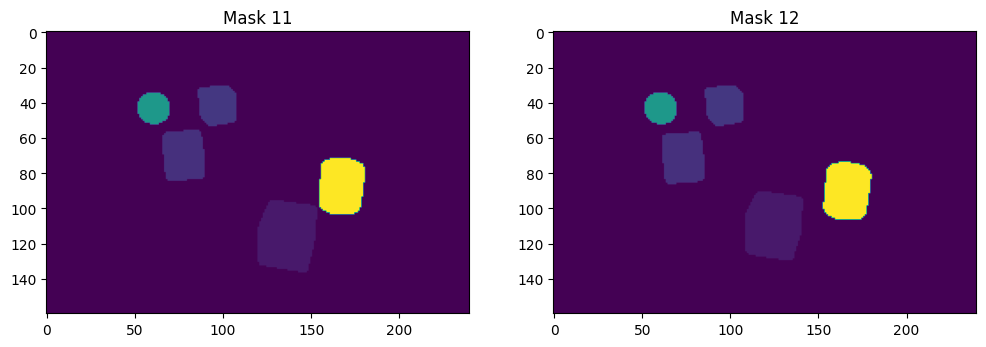

In [9]:
import matplotlib.pyplot as plt

# Get a batch
input, target = next(iter(dataloader))

input = input[0,:,10]
input = torch.argmax(input, dim=0)
#input = torch.argmax(input[0], dim=)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(input.cpu().numpy())
ax1.set_title("Mask 11")
ax2.imshow(target[0].cpu().numpy())
ax2.set_title("Mask 12")
plt.show()
# Reverse process before displaying
#input = input.cpu().numpy()  

#for video in input.squeeze(1)[:3]:          # Loop over videos
#    with io.BytesIO() as gif:
#        imageio.mimsave(gif,video.astype(np.uint8),"GIF",fps=5)
#        display(HBox([widgets.Image(value=gif.getvalue())]))

In [12]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
# The input video frames are 49 classes, thus 49 one-hot channels
model = Seq2Seq(num_channels=49, num_kernels=64, 
kernel_size=(3, 3), padding=(1, 1), activation="relu", 
frame_size=(160, 240), num_layers=3).to(device)

num_epochs = 3
steps = num_epochs * len(dataloader)
optim = AdamW(model.parameters(), lr=1e-4, weight_decay=0.005)
scheduler = CosineAnnealingLR(optim, T_max=steps, eta_min=1e-8)

class_weights = torch.ones(49)
class_weights[0] = 0.5
class_weights = class_weights.to(device)

# Binary Cross Entropy, target pixel values either 0 or 1
criterion = nn.CrossEntropyLoss(weight=class_weights)

Epoch:1 Batch:1625/1625 Loss:0.11382302641868591: 100%|██████████| 1625/1625 [36:55<00:00,  1.36s/it]


torch.Size([8, 49, 160, 240])
torch.Size([49, 160, 240])


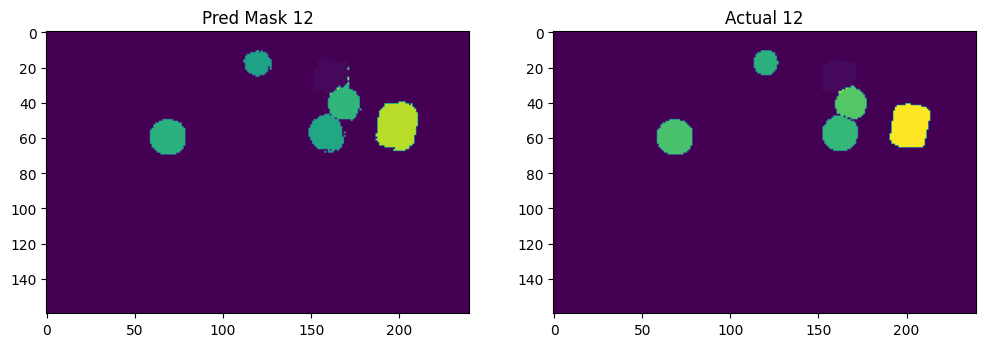

Epoch:1 Training Loss:0.0328816112148074


Epoch:2 Batch:1625/1625 Loss:0.18911923468112946: 100%|██████████| 1625/1625 [36:55<00:00,  1.36s/it]


torch.Size([8, 49, 160, 240])
torch.Size([49, 160, 240])


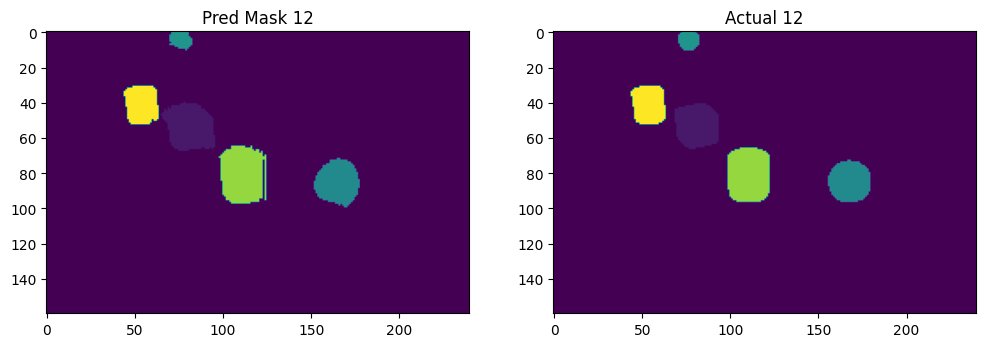

Epoch:2 Training Loss:0.020855257614587362


Epoch:3 Batch:1625/1625 Loss:0.16923286020755768: 100%|██████████| 1625/1625 [36:52<00:00,  1.36s/it]


torch.Size([8, 49, 160, 240])
torch.Size([49, 160, 240])


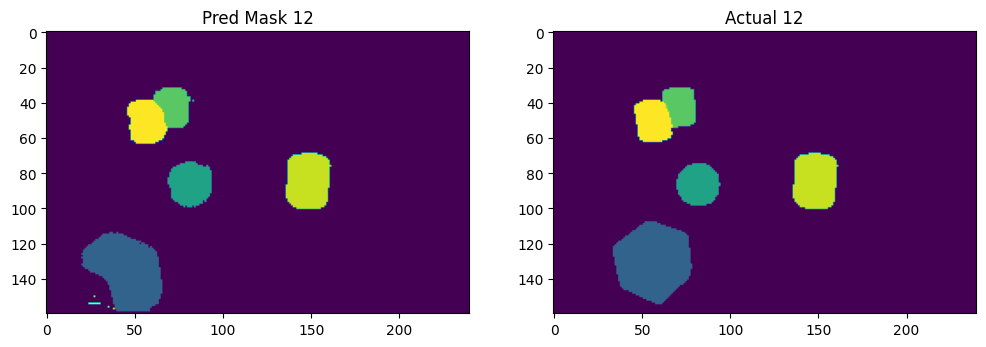

Epoch:3 Training Loss:0.019545288279652597


Epoch:4 Batch:674/1625 Loss:0.16248220205307007:  41%|████▏     | 674/1625 [14:57<21:06,  1.33s/it]


KeyboardInterrupt: ignored

In [13]:
from tqdm import tqdm

for epoch in range(1, num_epochs+1):
    
    train_loss = 0                                                 
    model.train()                                                  
    pbar = tqdm(enumerate(dataloader), total=len(dataloader))
    for batch_num, (input, target) in pbar:
        #input, target = input.to(device), target.to(device)
        output = model(input)
        #print(output.shape)
        #print(target.shape)                            
        loss = criterion(output, target)       
        loss.backward()                                            
        optim.step()                                               
        optim.zero_grad()                                           
        train_loss += loss.item()
        scheduler.step()
        pbar.set_description(f"Epoch:{epoch} Batch:{batch_num+1}/{len(dataloader)} Loss:{loss.item()}")
    
    #pbar = tq
    
    print(output.shape)
    output_example = output[0,:]
    print(output_example.shape)
    output_example = torch.argmax(output_example, dim=0)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(output_example.cpu().numpy())
    ax1.set_title("Pred Mask 12")
    ax2.imshow(target[0].cpu().numpy())
    ax2.set_title("Actual 12")
    plt.show()

    train_loss /= len(dataloader.dataset)
    print(f"Epoch:{epoch} Training Loss:{train_loss}")


In [18]:
torch.save(model.state_dict(), "LSTM_best_model_3_epochs.pkl")

torch.Size([8, 49, 160, 240])
torch.Size([49, 160, 240])


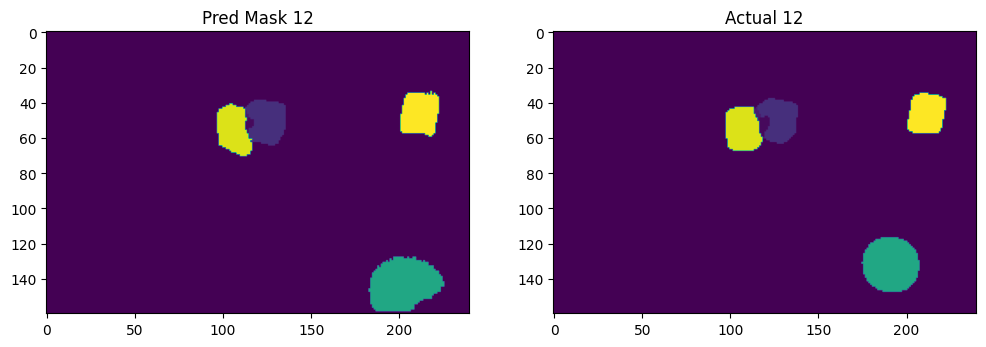

In [14]:
print(output.shape)
output_example = output[0,:]
print(output_example.shape)
output_example = torch.argmax(output_example, dim=0)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(output_example.cpu().numpy())
ax1.set_title("Pred Mask 12")
ax2.imshow(target[0].cpu().numpy())
ax2.set_title("Actual 12")
plt.show()

In [15]:
!pip install torchmetrics
import torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 9.5 MB/s eta 0:00:00


In [19]:
### Dataloader method
def load_data_unshuffled(root, annotation_file, batch_size=2):
    preprocess = transforms.Compose([
            ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
            # transforms.Resize(299),  # image batch, resize smaller edge to 299
            # transforms.Resize((160,240)),
            # transforms.CenterCrop(299),  # image batch, center crop to square 299x299
            transforms.Normalize((0.61749697, 0.6050092, 0.52180636), (2.1824553, 2.1553133, 1.9115673)),
        ])

    dataset = VideoFrameDataset(
        root_path=root,
        annotationfile_path=annotation_file,
        num_segments=1,
        frames_per_segment=22,
        imagefile_template='image_{:d}.png',
        transform=preprocess,
        mask=True,
        test_mode=False
    )

    dataloader = torch.utils.data.DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=2, # arbitrarily chosen
            pin_memory=True
        )
    return dataloader

valloader = load_data_unshuffled('Dataset_Student/val/data/', 'Dataset_Student/val/annotations.txt', batch_size=2)

In [16]:
def compute_jaccard(ground_truth_mask, predicted_mask):
  jaccard = torchmetrics.JaccardIndex(task="multiclass", num_classes=49) #.to(device)
  return jaccard(torch.Tensor(ground_truth_mask), torch.Tensor(predicted_mask))

100%|██████████| 500/500 [04:24<00:00,  1.89it/s]


Jaccard Score: 0.09964880347251892


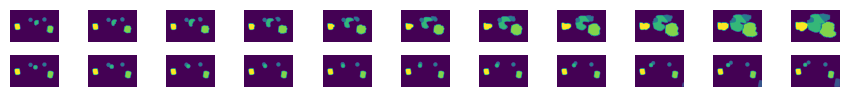

In [23]:
### Compute Jaccard
### Show predicted vs actual
def validate_model(model, valloader, index_to_show):
  model.eval()
  predicted_masks_22 = []
  actual_masks_22 = []
  predicted_masks_show = []
  actual_masks_show = []
  pbar = tqdm(enumerate(valloader), total=len(valloader))
  with torch.no_grad():
    for batch_num, (input, label, masks) in pbar:
      input, label, masks = input.to(device), label.to(device), masks.to(device)

      if batch_num == index_to_show:
        actual_masks_show = masks[0,11:].cpu()

      context = one_hot_encoding(masks[:,:11], 49)
      for frame in range(11):

        pred = model(context)
        pred = torch.argmax(pred, dim=1)
        if frame == 10:
          predicted_masks_22.append(pred[:].cpu())
          actual_masks_22.append(masks[:,21].cpu())
        if batch_num == index_to_show:
          predicted_masks_show.append(pred[0].cpu())
        
        pred = one_hot_encoding(pred.unsqueeze(1))
        context = context[:,:,-10:]
        context = torch.cat([context, pred], dim=2)
    
    predicted_masks_22 = torch.cat(predicted_masks_22, dim=0)
    actual_masks_22 = torch.cat(actual_masks_22, dim=0)
    jaccard = compute_jaccard(actual_masks_22, predicted_masks_22)
    print(f"Jaccard Score: {jaccard}")

    plot_model_result(predicted_masks_show, actual_masks_show)


def plot_model_result(pred, actual):
    """
    Plot and save figure
    """
    num_frames = len(pred)
    fig, ax = plt.subplots(2, num_frames, figsize = (num_frames, 1))
    fig.subplots_adjust(wspace=0.1, hspace = 0.4)

    for j in range(num_frames):
      ax[0,j].set_axis_off()
      ax[1,j].set_axis_off()
      
      img_pred = pred[j]
      img_actual = actual[j]

      #img_pred = transforms.ToPILImage()(img)

      ax[0,j].imshow(img_pred)
      ax[1,j].imshow(img_actual)
    # fig.savefig(f'{fig_name}.pdf', bbox_inches = 'tight')

validate_model(model, valloader, 30)

In [ ]:
def collate_test(batch):

    # Last 10 frames are target
    target = np.array(batch)[:,10:]                     
    
    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)          
    batch = batch / 255.0                             
    batch = batch.to(device)                          
    return batch, target

# Test Data Loader
test_loader = DataLoader(test_data,shuffle=True, 
                         batch_size=3, collate_fn=collate_test)

# Get a batch
batch, target = next(iter(test_loader))

# Initialize output sequence
output = np.zeros(target.shape, dtype=np.uint8)

# Loop over timesteps
for timestep in range(target.shape[1]):
  input = batch[:,:,timestep:timestep+10]   
  output[:,timestep]=(model(input).squeeze(1).cpu()>0.5)*255.0

In [ ]:
for tgt, out in zip(target, output):       # Loop over samples
    
    # Write target video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, tgt, "GIF", fps = 5)    
        target_gif = gif.getvalue()

    # Write output video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, out, "GIF", fps = 5)    
        output_gif = gif.getvalue()

    display(HBox([widgets.Image(value=target_gif), 
                  widgets.Image(value=output_gif)]))